# Mini CNN Image Classifier + Topology (Persistent Homology) Detector (Synthetic Images)

This notebook tests the repo’s **topology-based detector** (`detector_type='topology_score'`) on an **image-like** setting using a **fully synthetic 2-class RGB dataset**.

In [1]:
import os
import sys
import importlib
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Project root
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data import create_data_loaders
from src.models import train_model, evaluate_model, extract_features_batch, get_model_predictions
from src.detectors import train_graph_detector
from src.evaluation import evaluate_detector
from src.topology_features import TopologyConfig, local_persistence_features
from src.utils import ExperimentConfig, set_seed
from src.visualization import plot_roc_from_metrics, plot_confusion_matrix, plot_score_distributions_figure

In [2]:
# Configuration
SEED = 42
set_seed(SEED)

DEVICE = "cpu"

# Dataset sizes
N_TRAIN = 2000
N_VAL = 500
N_TEST = 500

# Training
EPOCHS = 8
BATCH_SIZE = 64
LR = 1e-3

# Attack (inputs in [0,1])
ATTACK_TYPE = 'fgsm'  # 'fgsm' or 'pgd'
EPSILON = 0.03
PGD_STEPS = 10
PGD_STEP_SIZE = 0.007

# Topology detector settings
TOPO_K = 40
TOPO_MAXDIM = 1
TOPO_PREPROCESS = 'pca'
TOPO_PCA_DIM = 10
TOPO_MIN_PERSISTENCE = 1e-6

TOPO_PERCENTILE = 95.0
TOPO_COV_SHRINKAGE = 1e-3

# PH can be expensive; subsample scoring points
MAX_POINTS_FOR_SCORING = 250

print(f"Attack: {ATTACK_TYPE}, eps={EPSILON}")
print(f"Topology: k={TOPO_K}, maxdim={TOPO_MAXDIM}, preprocess={TOPO_PREPROCESS}({TOPO_PCA_DIM})")

Attack: fgsm, eps=0.03
Topology: k=40, maxdim=1, preprocess=pca(10)


In [3]:
# Helpers
from typing import Tuple, Dict

from src.data import load_synthetic_shapes_2class


def plot_samples(X: np.ndarray, y: np.ndarray, *, title: str, n_show: int = 8):
    fig, axes = plt.subplots(1, n_show, figsize=(2.2 * n_show, 2.2))
    for i in range(n_show):
        img = X[i].transpose(1, 2, 0)
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"y={int(y[i])}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


from src.models import MiniCNN
from src.adv_attacks import generate_adversarial_examples_images


def compute_success_mask(model: nn.Module, X_clean: np.ndarray, X_adv: np.ndarray, y: np.ndarray, device: str):
    pred_clean = get_model_predictions(model, X_clean, device=device)
    pred_adv = get_model_predictions(model, X_adv, device=device)
    clean_correct = (pred_clean == y)
    success = clean_correct & (pred_adv != y)
    return pred_clean, pred_adv, clean_correct, success


def show_successful_attacks(
    X_clean: np.ndarray,
    X_adv: np.ndarray,
    y_true: np.ndarray,
    pred_clean: np.ndarray,
    pred_adv: np.ndarray,
    success_mask: np.ndarray,
    *,
    epsilon: float,
    n_show: int = 6,
    seed: int = 0,
):
    idx = np.where(success_mask)[0]
    if len(idx) == 0:
        print("No successful attacks to show.")
        return
    rng = np.random.default_rng(seed)
    chosen = rng.choice(idx, size=min(n_show, len(idx)), replace=False)

    fig, axes = plt.subplots(len(chosen), 2, figsize=(7, 3 * len(chosen)))
    if len(chosen) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, i in enumerate(chosen):
        clean = np.clip(X_clean[i].transpose(1, 2, 0), 0, 1)
        adv = np.clip(X_adv[i].transpose(1, 2, 0), 0, 1)
        axes[r, 0].imshow(clean); axes[r, 0].axis('off'); axes[r, 0].set_title(f"clean y={int(y_true[i])}, pred={int(pred_clean[i])}")
        axes[r, 1].imshow(adv); axes[r, 1].axis('off'); axes[r, 1].set_title(f"adv pred={int(pred_adv[i])} (eps={epsilon})")

    plt.tight_layout(); plt.show()


def compute_topology_feature_scores(
    X_points: np.ndarray,
    *,
    model: nn.Module,
    Z_train: np.ndarray,
    graph_cfg,
    device: str,
    layer: str = 'penultimate',
) -> Dict[str, np.ndarray]:
    from sklearn.neighbors import NearestNeighbors

    if graph_cfg.space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer=layer, device=device)
    else:
        Z_points = X_points

    topo_cfg = TopologyConfig(
        neighborhood_k=int(getattr(graph_cfg, 'topo_k', 50)),
        maxdim=int(getattr(graph_cfg, 'topo_maxdim', 1)),
        metric=str(getattr(graph_cfg, 'topo_metric', 'euclidean')),
        thresh=getattr(graph_cfg, 'topo_thresh', None),
        min_persistence=float(getattr(graph_cfg, 'topo_min_persistence', 1e-6)),
        preprocess=str(getattr(graph_cfg, 'topo_preprocess', 'none')),
        pca_dim=int(getattr(graph_cfg, 'topo_pca_dim', 10)),
    )

    nbrs = NearestNeighbors(n_neighbors=min(topo_cfg.neighborhood_k, len(Z_train)), metric=topo_cfg.metric).fit(Z_train)

    feat_dicts = []
    for i in range(len(Z_points)):
        _, idx = nbrs.kneighbors(Z_points[i].reshape(1, -1))
        neighborhood = Z_train[idx[0]]
        cloud = np.vstack([Z_points[i].reshape(1, -1), neighborhood])
        feat_dicts.append(local_persistence_features(cloud, topo_cfg))

    all_keys = sorted({k for d in feat_dicts for k in d.keys()})
    return {k: np.array([d.get(k, 0.0) for d in feat_dicts], dtype=float) for k in all_keys}


def concat_scores(scores_a: Dict[str, np.ndarray], scores_b: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    keys = sorted(set(scores_a.keys()) | set(scores_b.keys()))
    out: Dict[str, np.ndarray] = {}
    for k in keys:
        a = scores_a.get(k)
        b = scores_b.get(k)
        if a is None:
            a = np.zeros(len(next(iter(scores_a.values()))), dtype=float)
        if b is None:
            b = np.zeros(len(next(iter(scores_b.values()))), dtype=float)
        out[k] = np.concatenate([a, b])
    return out


def subsample_masked(X: np.ndarray, y: np.ndarray, mask: np.ndarray, n_max: int, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return X[:0], y[:0]
    if len(idx) > n_max:
        idx = rng.choice(idx, size=n_max, replace=False)
    return X[idx], y[idx]


In [4]:
# Load dataset
DATASET_NAME = "SyntheticShapes(2class)"
X_train, y_train, X_val, y_val, X_test, y_test = load_synthetic_shapes_2class(
    n_train=N_TRAIN, n_val=N_VAL, n_test=N_TEST, seed=SEED, image_size=32
)

print(f"Dataset: {DATASET_NAME}")
print(f"X_train: {X_train.shape} | y mean: {y_train.mean():.3f}")
print(f"X_val:   {X_val.shape} | y mean: {y_val.mean():.3f}")
print(f"X_test:  {X_test.shape} | y mean: {y_test.mean():.3f}")

Dataset: SyntheticShapes(2class)
X_train: (2000, 3, 32, 32) | y mean: 0.489
X_val:   (500, 3, 32, 32) | y mean: 0.526
X_test:  (500, 3, 32, 32) | y mean: 0.518


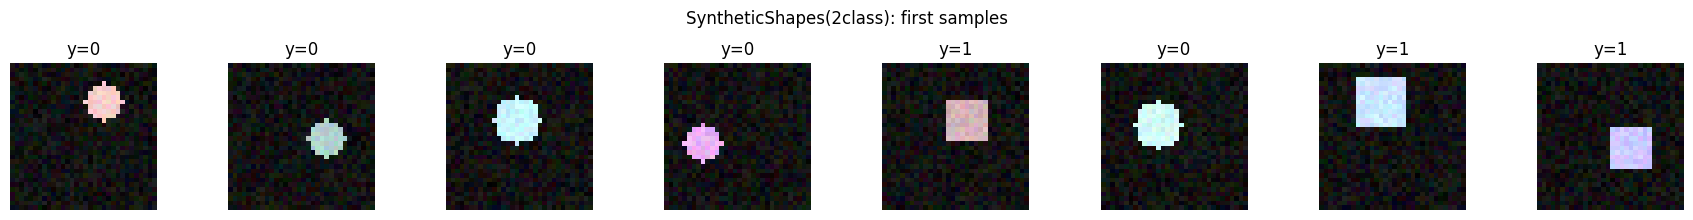

In [5]:
# Visual sanity-check
plot_samples(X_train, y_train, title=f"{DATASET_NAME}: first samples", n_show=8)

In [6]:
# Model + experiment config
config = ExperimentConfig(seed=SEED, device=DEVICE)

config.model.epochs = EPOCHS
config.model.batch_size = BATCH_SIZE
config.model.learning_rate = LR

config.attack.attack_type = ATTACK_TYPE
config.attack.epsilon = EPSILON
config.attack.num_steps = PGD_STEPS
config.attack.step_size = PGD_STEP_SIZE
config.attack.random_start = True

config.graph.space = 'feature'
config.graph.use_topology = True
config.graph.use_tangent = False
config.graph.topo_k = TOPO_K
config.graph.topo_maxdim = TOPO_MAXDIM
config.graph.topo_preprocess = TOPO_PREPROCESS
config.graph.topo_pca_dim = TOPO_PCA_DIM
config.graph.topo_min_persistence = TOPO_MIN_PERSISTENCE

config.detector.detector_type = 'topology_score'
config.detector.topo_percentile = TOPO_PERCENTILE
config.detector.topo_cov_shrinkage = TOPO_COV_SHRINKAGE

model = MiniCNN(num_classes=2, feat_dim=128)
print(model)

MiniCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


In [7]:
# Train
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=config.model.batch_size,
)

history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=True)

test_loss, test_acc = evaluate_model(model, test_loader, device=config.device)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

Test loss: 0.0003 | Test accuracy: 100.00%


In [8]:
# Adversarial examples + success masks
X_adv_val = generate_adversarial_examples_images(
    model, X_val, y_val,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)
X_adv_test = generate_adversarial_examples_images(
    model, X_test, y_test,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)

EVAL_ONLY_SUCCESSFUL_ATTACKS = True
FILTER_CLEAN_TO_CORRECT = True

pred_val_clean, pred_val_adv, val_clean_correct, val_success = compute_success_mask(model, X_val, X_adv_val, y_val, device=DEVICE)
pred_test_clean, pred_test_adv, test_clean_correct, test_success = compute_success_mask(model, X_test, X_adv_test, y_test, device=DEVICE)

print(f"Val successful attacks:  {val_success.sum()}/{len(val_success)} = {val_success.mean():.3f}")
print(f"Test successful attacks: {test_success.sum()}/{len(test_success)} = {test_success.mean():.3f}")

Val successful attacks:  280/500 = 0.560
Test successful attacks: 274/500 = 0.548


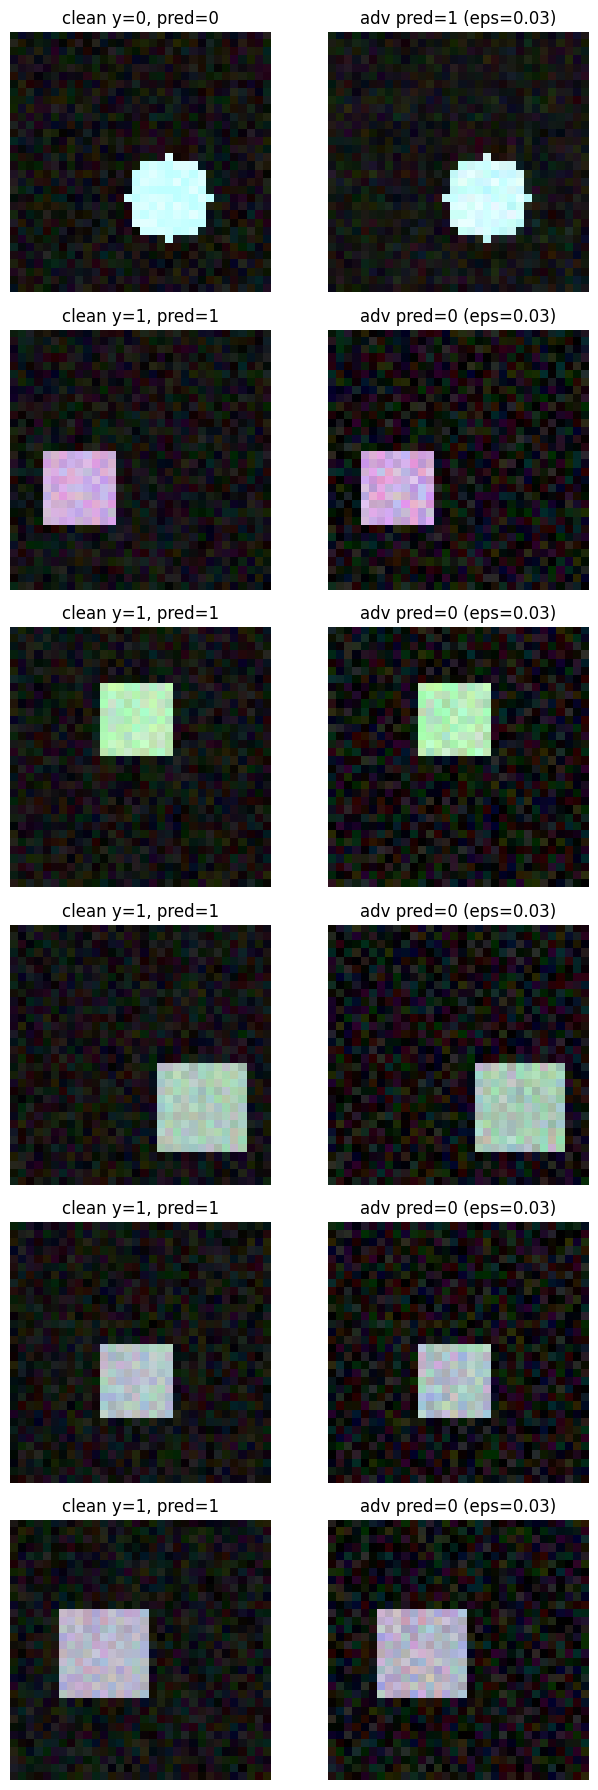

In [9]:
# Visualize a few successful attacks
show_successful_attacks(
    X_test, X_adv_test, y_test,
    pred_test_clean, pred_test_adv,
    test_success,
    epsilon=EPSILON,
    n_show=6,
    seed=SEED,
)

In [10]:
# Reference embedding set from TRAIN
Z_train = extract_features_batch(model, X_train, layer='penultimate', device=DEVICE)
print(f"Z_train: {Z_train.shape}")

Z_train: (2000, 128)


In [11]:
# Topology-score detector
clean_mask_val = val_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_val), dtype=bool)
clean_mask_test = test_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_test), dtype=bool)
adv_mask_val = val_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_val), dtype=bool)
adv_mask_test = test_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_test), dtype=bool)

X_val_clean_used, _ = subsample_masked(X_val, y_val, clean_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED)
X_test_clean_used, _ = subsample_masked(X_test, y_test, clean_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 1)
X_val_adv_used, _ = subsample_masked(X_adv_val, y_val, adv_mask_val, MAX_POINTS_FOR_SCORING, seed=SEED + 2)
X_test_adv_used, _ = subsample_masked(X_adv_test, y_test, adv_mask_test, MAX_POINTS_FOR_SCORING, seed=SEED + 3)

scores_val_clean = compute_topology_feature_scores(X_val_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_val_adv = compute_topology_feature_scores(X_val_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

scores_test_clean = compute_topology_feature_scores(X_test_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_test_adv = compute_topology_feature_scores(X_test_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
any_key = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key]), dtype=int),
    np.ones(len(scores_val_adv[any_key]), dtype=int),
])

detector = train_graph_detector(scores_val_all, labels_val, config.detector)

scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
labels_test = np.concatenate([
    np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
    np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
])

score_fn = getattr(detector, 'score', None)
assert callable(score_fn)
raw_scores_test = np.asarray(score_fn(scores_test_all), dtype=float)
metrics = evaluate_detector(labels_test, raw_scores_test)

print("Detector performance (topology_mahalanobis):")
print(f"  AUROC:     {metrics['roc_auc']:.4f}")
print(f"  AUPRC:     {metrics['pr_auc']:.4f}")
print(f"  FPR@95TPR: {metrics['fpr_at_tpr95']:.4f}")

Detector performance (topology_mahalanobis):
  AUROC:     0.9793
  AUPRC:     0.9797
  FPR@95TPR: 0.1320


# Mini CNN Image Classifier + Topology (Persistent Homology) Detector (Synthetic Images)

This notebook extends the repository’s **topology-based detector** (`detector_type='topology_score'`) to an **image-like** setting using a **fully synthetic 2-class RGB dataset**.

We will:

- generate a simple synthetic image dataset (circles vs squares),
- train a small CNN,
- generate adversarial examples (FGSM/PGD) in pixel space,
- extract penultimate-layer embeddings,
- compute local persistent-homology (PH) summary features on kNN neighborhoods in embedding space,
- fit a `TopologyScoreDetector` (Mahalanobis-to-clean + percentile threshold),
- evaluate detection metrics (AUROC/AUPRC/FPR@95%TPR).

Notes:
- This uses **no torchvision** and performs **no dataset downloads**.
- Persistent homology requires `ripser` (already in this repo’s `requirements.txt`).

In [12]:
import os
import sys
import importlib
import numpy as np

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Project root
CWD = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CWD, "..")) if os.path.basename(CWD) == "notebooks" else os.path.abspath(CWD)
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data import create_data_loaders
from src.models import train_model, evaluate_model, extract_features_batch, get_model_logits, get_model_predictions
from src.detectors import train_graph_detector
from src.evaluation import evaluate_detector
from src.topology_features import TopologyConfig, local_persistence_features
from src.utils import ExperimentConfig, set_seed
from src.visualization import plot_roc_from_metrics, plot_confusion_matrix, plot_score_distributions_figure

In [13]:
# Configuration
SEED = 42
set_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset sizes (keep small for fast CPU runs + PH runtime)
N_TRAIN = 2000
N_VAL = 500
N_TEST = 500

# Model training
EPOCHS = 8
BATCH_SIZE = 64
LR = 1e-3

# Attack settings (pixel-space; inputs in [0,1])
ATTACK_TYPE = 'fgsm'  # 'fgsm' or 'pgd'
EPSILON = 0.03        # typical for [0,1] images
PGD_STEPS = 10
PGD_STEP_SIZE = 0.007

# Topology detector settings (computed in feature space)
TOPO_K = 40                 # neighborhood size for local PH
TOPO_MAXDIM = 1             # H0/H1
TOPO_PREPROCESS = 'pca'      # helps in high-d embedding spaces
TOPO_PCA_DIM = 10
TOPO_MIN_PERSISTENCE = 1e-6

TOPO_PERCENTILE = 95.0       # clean-score percentile threshold
TOPO_COV_SHRINKAGE = 1e-3

# Scoring subsampling (PH per point can be expensive)
MAX_POINTS_FOR_SCORING = 250

print(f"DEVICE: {DEVICE}")
print(f"Train/Val/Test: {N_TRAIN}/{N_VAL}/{N_TEST}")
print(f"Attack: {ATTACK_TYPE}, eps={EPSILON}")
print(f"Topology: k={TOPO_K}, maxdim={TOPO_MAXDIM}, preprocess={TOPO_PREPROCESS}({TOPO_PCA_DIM})")

DEVICE: cpu
Train/Val/Test: 2000/500/500
Attack: fgsm, eps=0.03
Topology: k=40, maxdim=1, preprocess=pca(10)


In [14]:
# Helpers (keep all reusable functions/classes here)
from typing import Tuple, Dict


from src.data import load_synthetic_shapes_2class


def load_dataset(
    *,
    n_train: int,
    n_val: int,
    n_test: int,
    seed: int,
) -> Tuple[str, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_train, y_train, X_val, y_val, X_test, y_test = load_synthetic_shapes_2class(
        n_train=n_train,
        n_val=n_val,
        n_test=n_test,
        seed=seed,
        image_size=32,
    )
    return "SyntheticShapes(2class)", X_train, y_train, X_val, y_val, X_test, y_test


def plot_samples(X: np.ndarray, y: np.ndarray, *, title: str, n_show: int = 8):
    fig, axes = plt.subplots(1, n_show, figsize=(2.2 * n_show, 2.2))
    for i in range(n_show):
        img = X[i].transpose(1, 2, 0)
        axes[i].imshow(np.clip(img, 0, 1))
        axes[i].set_title(f"y={int(y[i])}")
        axes[i].axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


from src.models import MiniCNN
from src.adv_attacks import generate_adversarial_examples_images


def compute_success_mask(model: nn.Module, X_clean: np.ndarray, X_adv: np.ndarray, y: np.ndarray, device: str):
    pred_clean = get_model_predictions(model, X_clean, device=device)
    pred_adv = get_model_predictions(model, X_adv, device=device)
    clean_correct = (pred_clean == y)
    success = clean_correct & (pred_adv != y)
    return pred_clean, pred_adv, clean_correct, success


def show_successful_attacks(
    X_clean: np.ndarray,
    X_adv: np.ndarray,
    y_true: np.ndarray,
    pred_clean: np.ndarray,
    pred_adv: np.ndarray,
    success_mask: np.ndarray,
    *,
    epsilon: float,
    n_show: int = 6,
    seed: int = 0,
):
    idx = np.where(success_mask)[0]
    if len(idx) == 0:
        print("No successful attacks to show. Try increasing EPSILON / PGD_STEPS.")
        return

    rng = np.random.default_rng(seed)
    chosen = rng.choice(idx, size=min(n_show, len(idx)), replace=False)

    fig, axes = plt.subplots(len(chosen), 2, figsize=(7, 3 * len(chosen)))
    if len(chosen) == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, i in enumerate(chosen):
        clean = np.clip(X_clean[i].transpose(1, 2, 0), 0, 1)
        adv = np.clip(X_adv[i].transpose(1, 2, 0), 0, 1)

        axes[r, 0].imshow(clean)
        axes[r, 0].axis('off')
        axes[r, 0].set_title(f"clean: y={int(y_true[i])}, pred={int(pred_clean[i])}")

        axes[r, 1].imshow(adv)
        axes[r, 1].axis('off')
        axes[r, 1].set_title(f"adv: pred={int(pred_adv[i])}  (eps={epsilon})")

    plt.suptitle(f"Successful attacks (n={len(idx)})")
    plt.tight_layout()
    plt.show()


def compute_topology_feature_scores(
    X_points: np.ndarray,
    *,
    model: nn.Module,
    Z_train: np.ndarray,
    graph_cfg,
    device: str,
    layer: str = 'penultimate',
) -> Dict[str, np.ndarray]:
    from sklearn.neighbors import NearestNeighbors

    if graph_cfg.space == 'feature':
        Z_points = extract_features_batch(model, X_points, layer=layer, device=device)
    else:
        Z_points = X_points

    topo_cfg = TopologyConfig(
        neighborhood_k=int(getattr(graph_cfg, 'topo_k', 50)),
        maxdim=int(getattr(graph_cfg, 'topo_maxdim', 1)),
        metric=str(getattr(graph_cfg, 'topo_metric', 'euclidean')),
        thresh=getattr(graph_cfg, 'topo_thresh', None),
        min_persistence=float(getattr(graph_cfg, 'topo_min_persistence', 1e-6)),
        preprocess=str(getattr(graph_cfg, 'topo_preprocess', 'none')),
        pca_dim=int(getattr(graph_cfg, 'topo_pca_dim', 10)),
    )

    nbrs = NearestNeighbors(
        n_neighbors=min(topo_cfg.neighborhood_k, len(Z_train)),
        metric=topo_cfg.metric,
    ).fit(Z_train)

    feat_dicts = []
    for i in range(len(Z_points)):
        _, idx = nbrs.kneighbors(Z_points[i].reshape(1, -1))
        neighborhood = Z_train[idx[0]]
        cloud = np.vstack([Z_points[i].reshape(1, -1), neighborhood])
        feat_dicts.append(local_persistence_features(cloud, topo_cfg))

    all_keys = sorted({k for d in feat_dicts for k in d.keys()})
    return {k: np.array([d.get(k, 0.0) for d in feat_dicts], dtype=float) for k in all_keys}


def concat_scores(scores_a: Dict[str, np.ndarray], scores_b: Dict[str, np.ndarray]) -> Dict[str, np.ndarray]:
    keys = sorted(set(scores_a.keys()) | set(scores_b.keys()))
    out: Dict[str, np.ndarray] = {}
    for k in keys:
        a = scores_a.get(k)
        b = scores_b.get(k)
        if a is None:
            a = np.zeros(len(next(iter(scores_a.values()))), dtype=float)
        if b is None:
            b = np.zeros(len(next(iter(scores_b.values()))), dtype=float)
        out[k] = np.concatenate([a, b])
    return out


def subsample_masked(X: np.ndarray, y: np.ndarray, mask: np.ndarray, n_max: int, seed: int) -> Tuple[np.ndarray, np.ndarray]:
    rng = np.random.default_rng(seed)
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return X[:0], y[:0]
    if len(idx) > n_max:
        idx = rng.choice(idx, size=n_max, replace=False)
    return X[idx], y[idx]


In [15]:
# Load dataset
DATASET_NAME, X_train, y_train, X_val, y_val, X_test, y_test = load_dataset(
    n_train=N_TRAIN,
    n_val=N_VAL,
    n_test=N_TEST,
    seed=SEED,
)

print(f"Dataset: {DATASET_NAME}")
print(f"X_train: {X_train.shape}, y_train mean: {y_train.mean():.3f}")
print(f"X_val:   {X_val.shape}, y_val mean:   {y_val.mean():.3f}")
print(f"X_test:  {X_test.shape}, y_test mean:  {y_test.mean():.3f}")


Dataset: SyntheticShapes(2class)
X_train: (2000, 3, 32, 32), y_train mean: 0.489
X_val:   (500, 3, 32, 32), y_val mean:   0.526
X_test:  (500, 3, 32, 32), y_test mean:  0.518


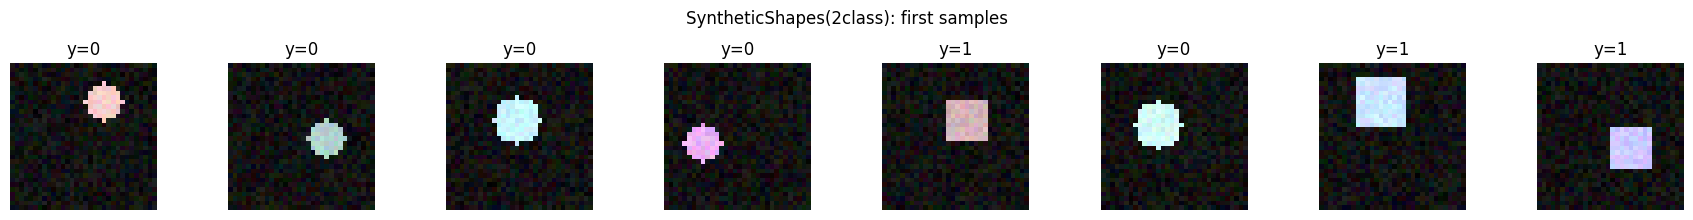

In [16]:
# Visual sanity-check
plot_samples(X_train, y_train, title=f"{DATASET_NAME}: first samples", n_show=8)


In [17]:
# Model + experiment config
config = ExperimentConfig(seed=SEED, device=DEVICE)

# Training
config.model.epochs = EPOCHS
config.model.batch_size = BATCH_SIZE
config.model.learning_rate = LR

# Attack
config.attack.attack_type = ATTACK_TYPE
config.attack.epsilon = EPSILON
config.attack.num_steps = PGD_STEPS
config.attack.step_size = PGD_STEP_SIZE
config.attack.random_start = True

# Topology features computed in feature space
config.graph.space = 'feature'
config.graph.use_topology = True
config.graph.use_tangent = False
config.graph.topo_k = TOPO_K
config.graph.topo_maxdim = TOPO_MAXDIM
config.graph.topo_preprocess = TOPO_PREPROCESS
config.graph.topo_pca_dim = TOPO_PCA_DIM
config.graph.topo_min_persistence = TOPO_MIN_PERSISTENCE

# Topology-score detector
config.detector.detector_type = 'topology_score'
config.detector.topo_percentile = TOPO_PERCENTILE
config.detector.topo_cov_shrinkage = TOPO_COV_SHRINKAGE

model = MiniCNN(num_classes=2, feat_dim=128)
print(model)


MiniCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (proj): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
)


Test loss: 0.0003 | Test accuracy: 100.00%


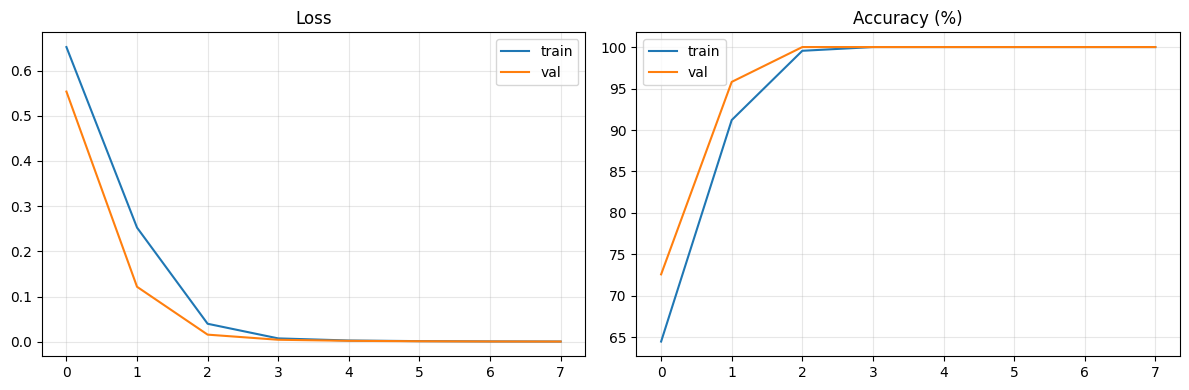

In [18]:
# Train
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train, X_val, y_val, X_test, y_test,
    batch_size=config.model.batch_size,
)

history = train_model(model, train_loader, val_loader, config.model, device=config.device, verbose=True)

test_loss, test_acc = evaluate_model(model, test_loader, device=config.device)
print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_acc:.2f}%")

# (Optional) training curves
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history['train_loss'], label='train'); axes[0].plot(history['val_loss'], label='val'); axes[0].set_title('Loss'); axes[0].grid(True, alpha=0.3); axes[0].legend()
axes[1].plot(history['train_acc'], label='train'); axes[1].plot(history['val_acc'], label='val'); axes[1].set_title('Accuracy (%)'); axes[1].grid(True, alpha=0.3); axes[1].legend()
plt.tight_layout(); plt.show()


In [19]:
# Adversarial examples + success masks
X_adv_val = generate_adversarial_examples_images(
    model, X_val, y_val,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)
X_adv_test = generate_adversarial_examples_images(
    model, X_test, y_test,
    attack_type=ATTACK_TYPE,
    epsilon=EPSILON,
    num_steps=PGD_STEPS,
    step_size=PGD_STEP_SIZE,
    device=DEVICE,
    batch_size=BATCH_SIZE,
)

# Successful = model correct on clean AND wrong on adv
EVAL_ONLY_SUCCESSFUL_ATTACKS = True
FILTER_CLEAN_TO_CORRECT = True

pred_val_clean, pred_val_adv, val_clean_correct, val_success = compute_success_mask(
    model, X_val, X_adv_val, y_val, device=DEVICE
)
pred_test_clean, pred_test_adv, test_clean_correct, test_success = compute_success_mask(
    model, X_test, X_adv_test, y_test, device=DEVICE
)

print(f"Val successful attacks:  {val_success.sum()}/{len(val_success)} = {val_success.mean():.3f}")
print(f"Test successful attacks: {test_success.sum()}/{len(test_success)} = {test_success.mean():.3f}")


Val successful attacks:  280/500 = 0.560
Test successful attacks: 274/500 = 0.548


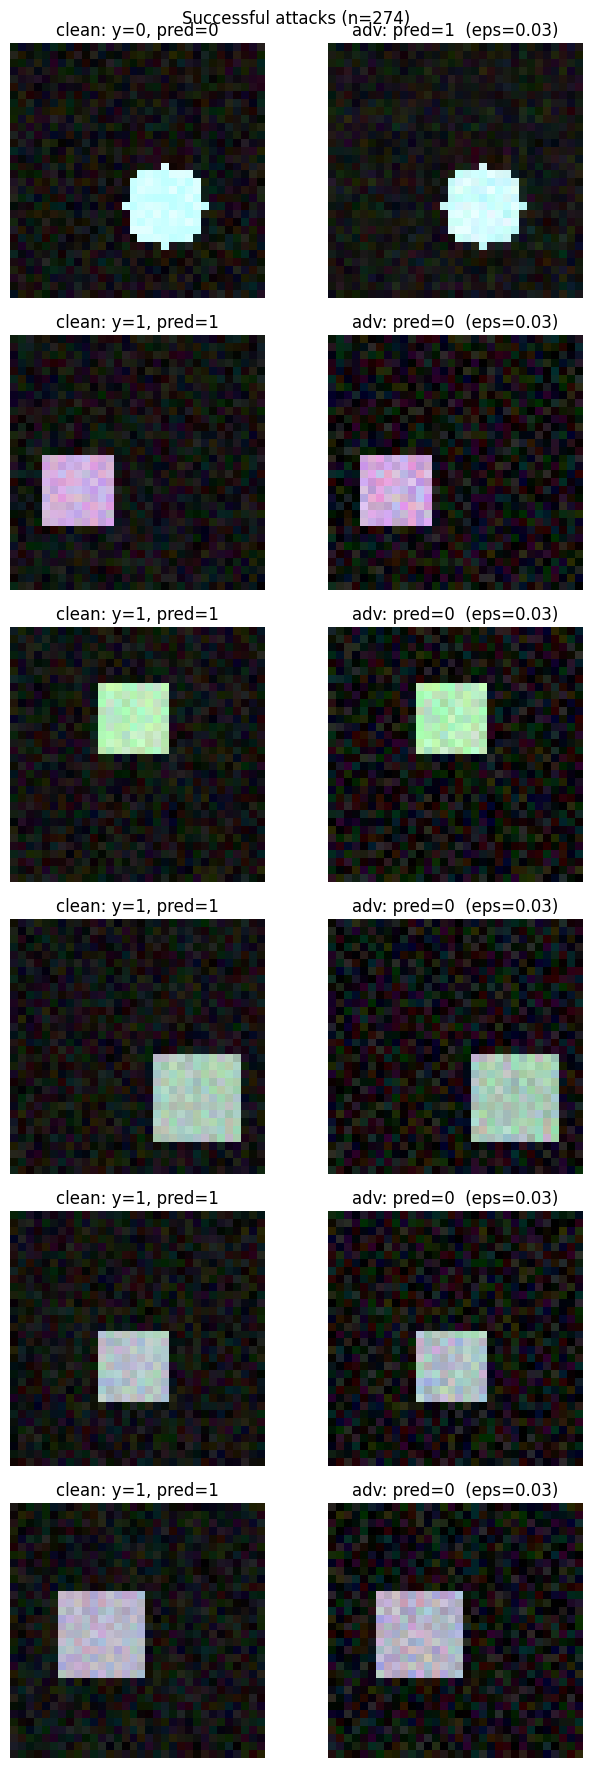

In [20]:
# Visualize a few successful attacks
show_successful_attacks(
    X_test,
    X_adv_test,
    y_test,
    pred_test_clean,
    pred_test_adv,
    test_success,
    epsilon=EPSILON,
    n_show=6,
    seed=SEED,
)


In [21]:
# Reference embedding set from TRAIN
Z_train = extract_features_batch(model, X_train, layer='penultimate', device=DEVICE)
print(f"Z_train: {Z_train.shape}")


Z_train: (2000, 128)


Scoring sizes: val clean=250, val adv=250
Scoring sizes: test clean=250, test adv=250

Detector performance (topology_mahalanobis score):
  AUROC:        0.9793
  AUPRC:        0.9797
  FPR@95%TPR:   0.1320
  threshold:    3.4996


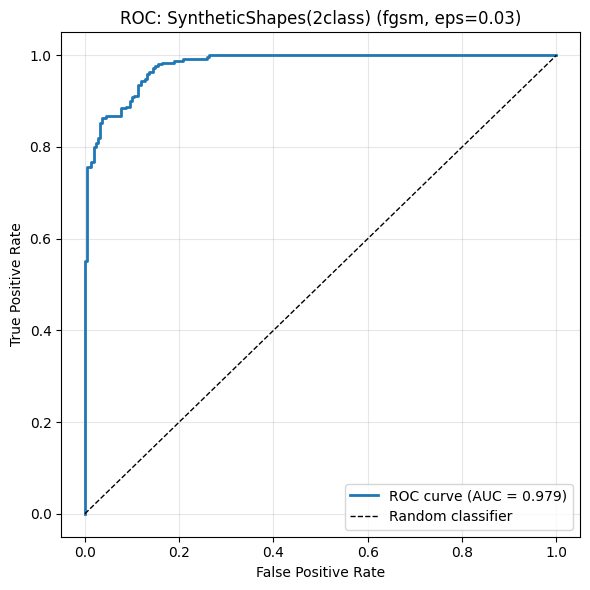

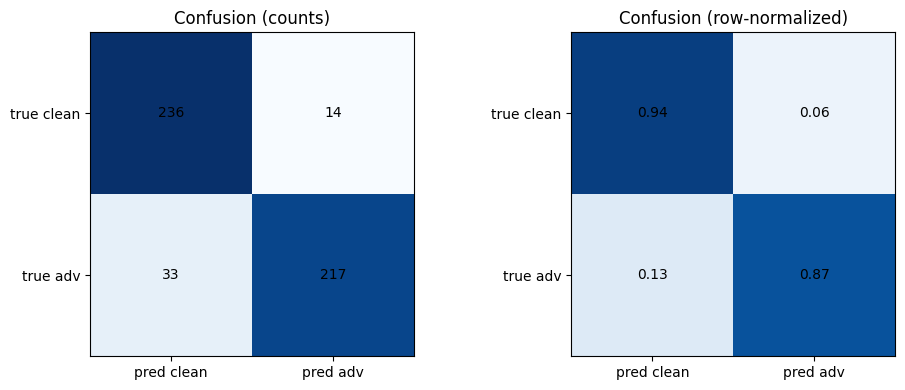

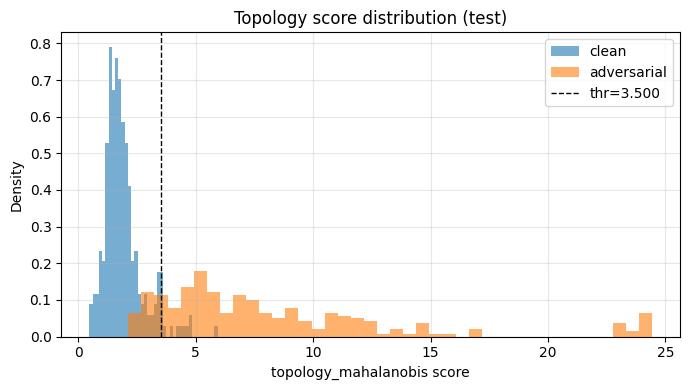

(<Figure size 700x400 with 1 Axes>,
 <Axes: title={'center': 'Topology score distribution (test)'}, xlabel='topology_mahalanobis score', ylabel='Density'>)

In [22]:
# Topology-score detector (PH feature vector -> Mahalanobis -> threshold)

# Choose which points participate in scoring
clean_mask_val = val_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_val), dtype=bool)
clean_mask_test = test_clean_correct if FILTER_CLEAN_TO_CORRECT else np.ones(len(X_test), dtype=bool)

adv_mask_val = val_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_val), dtype=bool)
adv_mask_test = test_success if EVAL_ONLY_SUCCESSFUL_ATTACKS else np.ones(len(X_adv_test), dtype=bool)

seed0 = int(getattr(config, 'seed', 42))
X_val_clean_used, _ = subsample_masked(X_val, y_val, clean_mask_val, MAX_POINTS_FOR_SCORING, seed=seed0)
X_test_clean_used, _ = subsample_masked(X_test, y_test, clean_mask_test, MAX_POINTS_FOR_SCORING, seed=seed0 + 1)
X_val_adv_used, _ = subsample_masked(X_adv_val, y_val, adv_mask_val, MAX_POINTS_FOR_SCORING, seed=seed0 + 2)
X_test_adv_used, _ = subsample_masked(X_adv_test, y_test, adv_mask_test, MAX_POINTS_FOR_SCORING, seed=seed0 + 3)

print(f"Scoring sizes: val clean={len(X_val_clean_used)}, val adv={len(X_val_adv_used)}")
print(f"Scoring sizes: test clean={len(X_test_clean_used)}, test adv={len(X_test_adv_used)}")

# Compute topology features
scores_val_clean = compute_topology_feature_scores(X_val_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_val_adv = compute_topology_feature_scores(X_val_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

scores_test_clean = compute_topology_feature_scores(X_test_clean_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)
scores_test_adv = compute_topology_feature_scores(X_test_adv_used, model=model, Z_train=Z_train, graph_cfg=config.graph, device=DEVICE)

# Train detector on val
scores_val_all = concat_scores(scores_val_clean, scores_val_adv)
any_key = next(iter(scores_val_all.keys()))
labels_val = np.concatenate([
    np.zeros(len(scores_val_clean[any_key]), dtype=int),
    np.ones(len(scores_val_adv[any_key]), dtype=int),
])

detector = train_graph_detector(scores_val_all, labels_val, config.detector)

# Evaluate on test
scores_test_all = concat_scores(scores_test_clean, scores_test_adv)
labels_test = np.concatenate([
    np.zeros(len(next(iter(scores_test_clean.values()))), dtype=int),
    np.ones(len(next(iter(scores_test_adv.values()))), dtype=int),
])

score_fn = getattr(detector, 'score', None)
assert callable(score_fn)
raw_scores_test = np.asarray(score_fn(scores_test_all), dtype=float)
metrics = evaluate_detector(labels_test, raw_scores_test)

print("\nDetector performance (topology_mahalanobis score):")
print(f"  AUROC:        {metrics['roc_auc']:.4f}")
print(f"  AUPRC:        {metrics['pr_auc']:.4f}")
print(f"  FPR@95%TPR:   {metrics['fpr_at_tpr95']:.4f}")
print(f"  threshold:    {float(getattr(detector, 'threshold', np.nan)):.4f}")

#Quick plots (shared utilities)
plot_roc_from_metrics(
    metrics,
    title=f"ROC: {DATASET_NAME} ({ATTACK_TYPE}, eps={EPSILON})",
)

thr = float(getattr(detector, 'threshold', np.nan))
if np.isfinite(thr):
    plot_confusion_matrix(labels_test, y_scores=raw_scores_test, threshold=thr, labels=("clean", "adv"))

thr = float(getattr(detector, 'threshold', np.nan))
raw_clean = raw_scores_test[: len(X_test_clean_used)]
raw_adv = raw_scores_test[len(X_test_clean_used):]
plot_score_distributions_figure(
    raw_clean,
    raw_adv,
    score_name='topology_mahalanobis score',
    title='Topology score distribution (test)',
    bins=40,
    threshold=thr,
    labels=('clean', 'adversarial'),
    alpha=0.6,
    density=True,
    figsize=(7, 4),
)


## Visualize Detector Steps with PH Diagrams

This section visualizes the detector pipeline step-by-step, showing:
1. Local neighborhood point cloud (in feature space)
2. Persistence diagrams (H0 and H1)
3. Topology summary features
4. Final detector score

We'll compare a clean non-flagged sample with an adversarial flagged sample.

In [23]:
# Helper function to compute topology features with diagrams for a single point
from typing import Sequence

def compute_topology_feature_scores_with_diagrams(
    X_point: np.ndarray,
    *,
    model: nn.Module,
    Z_train: np.ndarray,
    graph_cfg,
    device: str,
    layer: str = 'penultimate',
) -> Tuple[Dict[str, float], Sequence[np.ndarray], np.ndarray]:
    """Compute topology features with diagrams for a single point (for visualization)."""
    from sklearn.neighbors import NearestNeighbors
    
    if graph_cfg.space == 'feature':
        # For images, preserve dimensions: add batch dimension without flattening
        # X_point is likely (C, H, W) or (H, W, C), we need (1, C, H, W) or (1, H, W, C)
        if X_point.ndim == 3:
            # Add batch dimension: (C, H, W) -> (1, C, H, W) or (H, W, C) -> (1, H, W, C)
            X_point_batch = X_point[None, ...]
        elif X_point.ndim == 2:
            # For 2D data (like two-moons), flatten: (D,) -> (1, D)
            X_point_batch = X_point.reshape(1, -1)
        else:
            # Already has batch dimension or is 1D
            X_point_batch = X_point if X_point.ndim > 1 else X_point.reshape(1, -1)
        Z_point = extract_features_batch(model, X_point_batch, layer=layer, device=device)[0]
    else:
        Z_point = X_point
    
    topo_cfg = TopologyConfig(
        neighborhood_k=int(getattr(graph_cfg, 'topo_k', 50)),
        maxdim=int(getattr(graph_cfg, 'topo_maxdim', 1)),
        metric=str(getattr(graph_cfg, 'topo_metric', 'euclidean')),
        thresh=getattr(graph_cfg, 'topo_thresh', None),
        min_persistence=float(getattr(graph_cfg, 'topo_min_persistence', 1e-6)),
        preprocess=str(getattr(graph_cfg, 'topo_preprocess', 'none')),
        pca_dim=int(getattr(graph_cfg, 'topo_pca_dim', 10)),
    )
    
    nbrs = NearestNeighbors(
        n_neighbors=min(topo_cfg.neighborhood_k, len(Z_train)),
        metric=topo_cfg.metric,
    ).fit(Z_train)
    
    # Get neighborhood
    _, idx = nbrs.kneighbors(Z_point.reshape(1, -1))
    neighborhood = Z_train[idx[0]]
    # Ensure the query point participates in the complex
    cloud = np.vstack([Z_point.reshape(1, -1), neighborhood])
    
    # Compute PH features with diagrams
    features, diagrams = local_persistence_features(cloud, topo_cfg, return_diagrams=True)
    
    return features, diagrams, cloud

# Import visualization functions
from src.visualization import (
    plot_persistence_diagram, 
    plot_topology_summary_features, 
    plot_local_neighborhood
)
from src.detectors import predict_graph_detector

# Select examples for visualization
# 1. Clean non-flagged sample (low detector score)
clean_scores = detector.score(scores_test_clean)
clean_idx = np.argmin(clean_scores)  # Lowest score = most clean-like
print(f"Selected clean sample: index {clean_idx}, score={clean_scores[clean_idx]:.4f}")

# 2. Adversarial flagged sample (high detector score)
adv_scores = detector.score(scores_test_adv)
adv_idx = np.argmax(adv_scores)  # Highest score among adversarial
print(f"Selected adversarial sample: index {adv_idx}, score={adv_scores[adv_idx]:.4f}")

# Get predictions for context
predictions_test, _ = predict_graph_detector(detector, scores_test_all)
any_key = next(iter(scores_test_clean.keys()))
clean_pred_idx = clean_idx
adv_pred_idx = len(scores_test_clean[any_key]) + adv_idx
print(f"Clean sample flagged: {predictions_test[clean_pred_idx]}")
print(f"Adversarial sample flagged: {predictions_test[adv_pred_idx]}")

# Compute scores with diagrams for both samples
print("\nComputing topology features with diagrams for clean sample...")
clean_features, clean_diagrams, clean_cloud = compute_topology_feature_scores_with_diagrams(
    X_test_clean_used[clean_idx], model=model, Z_train=Z_train, 
    graph_cfg=config.graph, device=DEVICE
)

print("Computing topology features with diagrams for adversarial sample...")
adv_features, adv_diagrams, adv_cloud = compute_topology_feature_scores_with_diagrams(
    X_test_adv_used[adv_idx], model=model, Z_train=Z_train, 
    graph_cfg=config.graph, device=DEVICE
)

# Get detector scores
clean_detector_score = clean_scores[clean_idx]
adv_detector_score = adv_scores[adv_idx]

print(f"\nDetector scores:")
print(f"  Clean sample: {clean_detector_score:.4f} (threshold: {detector.threshold:.4f})")
print(f"  Adversarial sample: {adv_detector_score:.4f} (threshold: {detector.threshold:.4f})")

Selected clean sample: index 193, score=0.4685
Selected adversarial sample: index 52, score=24.4242
Clean sample flagged: 0
Adversarial sample flagged: 1

Computing topology features with diagrams for clean sample...
Computing topology features with diagrams for adversarial sample...

Detector scores:
  Clean sample: 0.4685 (threshold: 3.4996)
  Adversarial sample: 24.4242 (threshold: 3.4996)


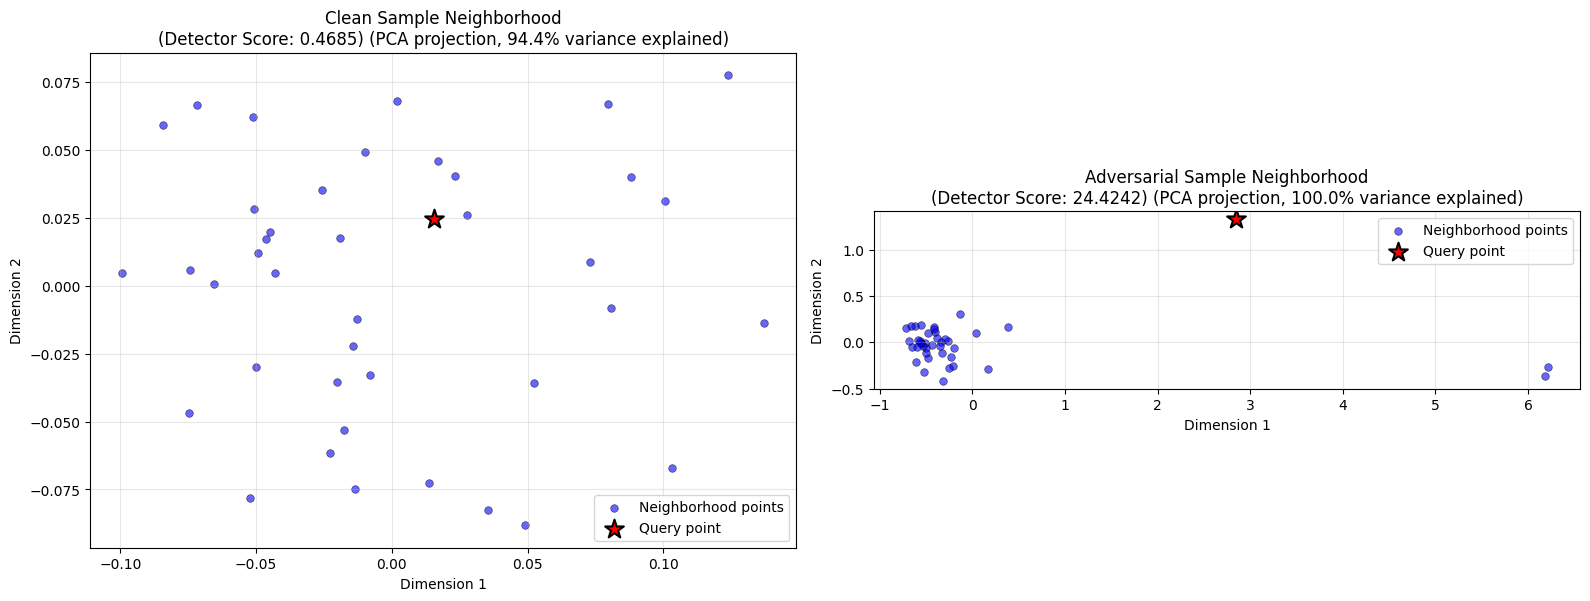

In [24]:
# Visualize local neighborhood point clouds
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Clean sample neighborhood
plot_local_neighborhood(
    clean_cloud,
    query_point=clean_cloud[0] if len(clean_cloud) > 0 else None,
    title=f"Clean Sample Neighborhood\n(Detector Score: {clean_detector_score:.4f})",
    ax=axes[0],
    max_dims=2
)

# Adversarial sample neighborhood
plot_local_neighborhood(
    adv_cloud,
    query_point=adv_cloud[0] if len(adv_cloud) > 0 else None,
    title=f"Adversarial Sample Neighborhood\n(Detector Score: {adv_detector_score:.4f})",
    ax=axes[1],
    max_dims=2
)

plt.tight_layout()
plt.show()

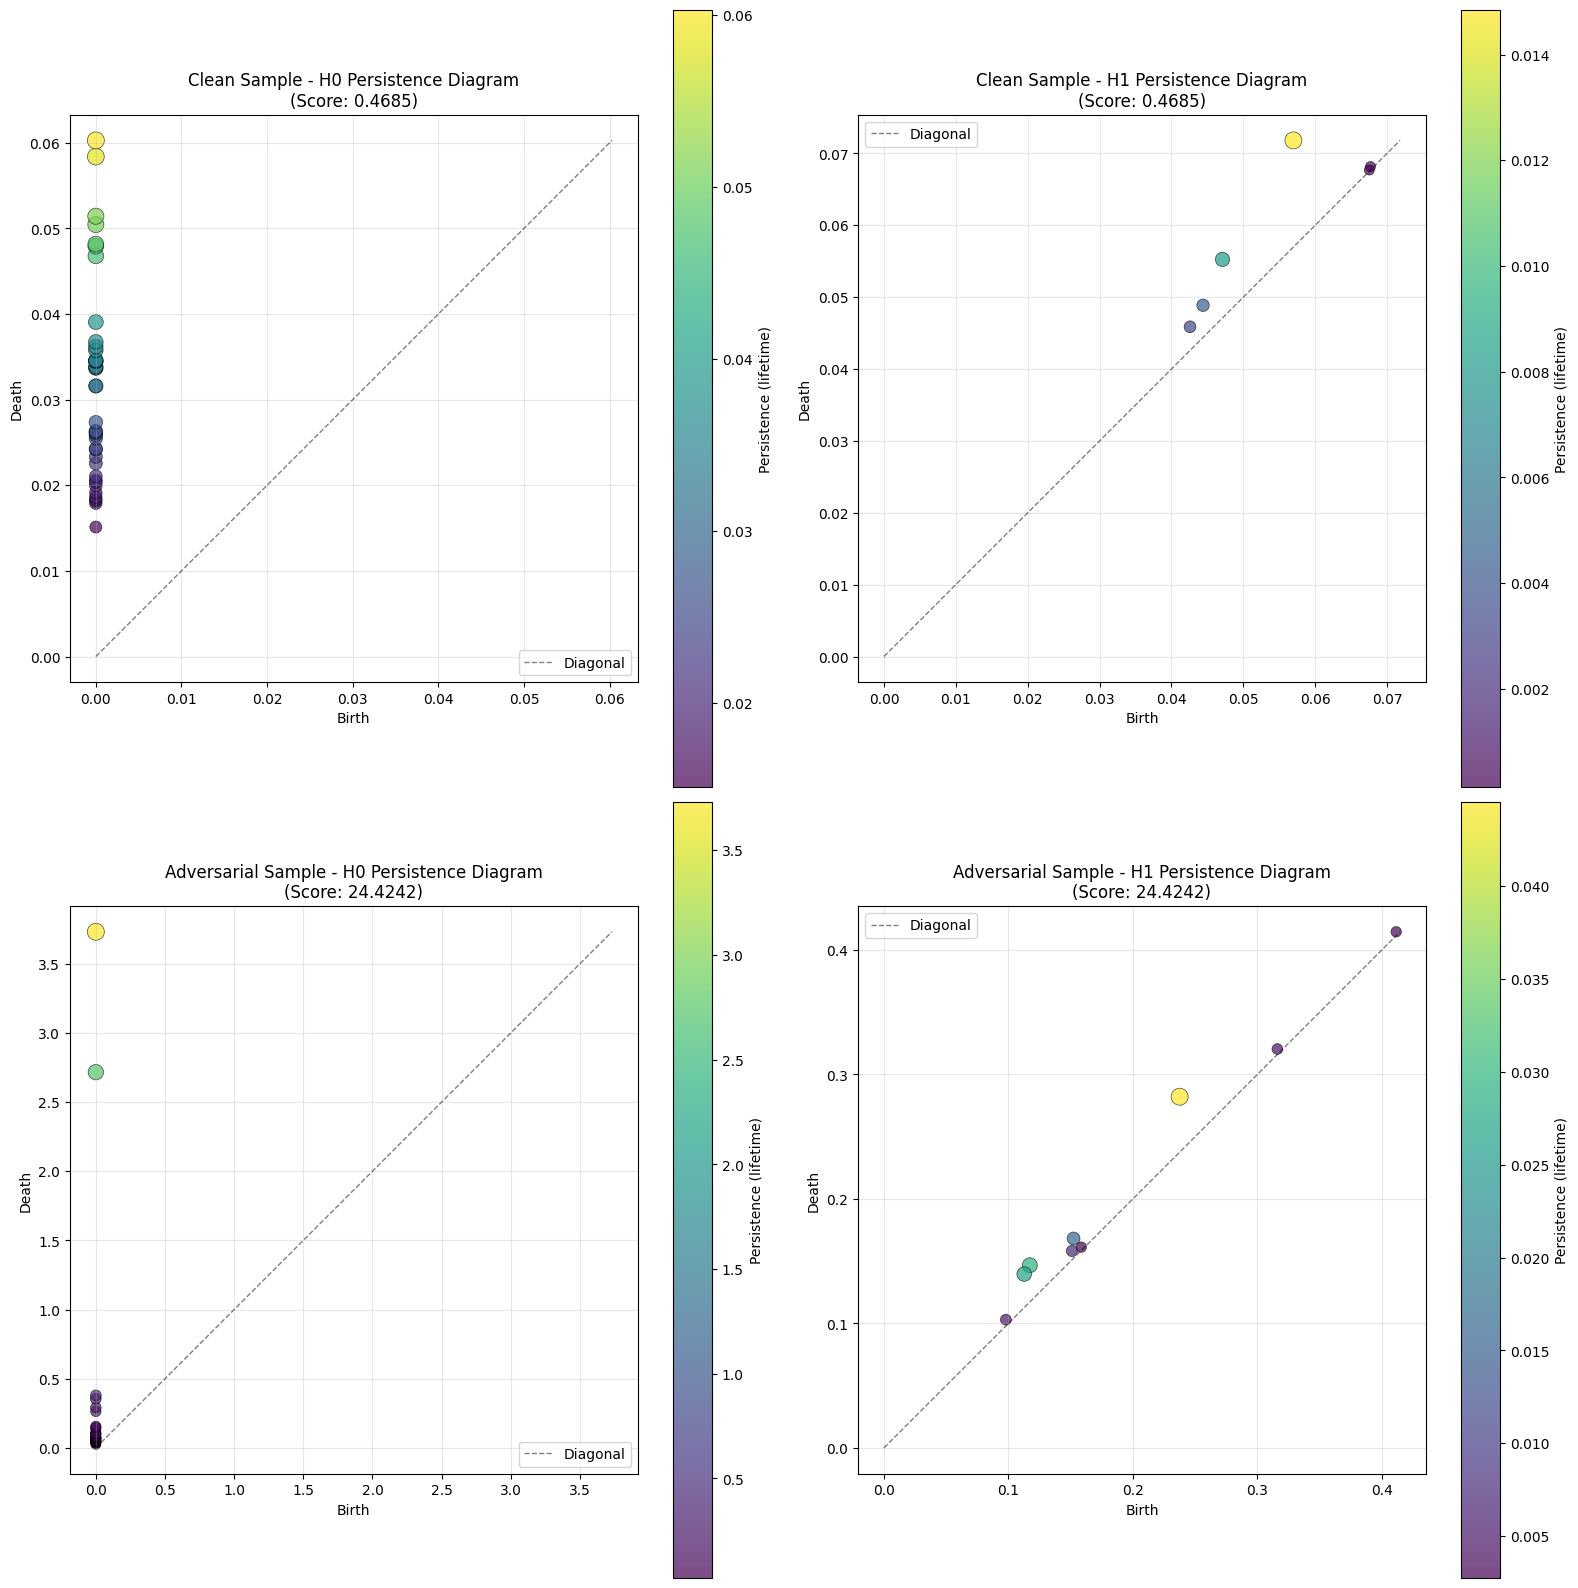

In [25]:
# Visualize persistence diagrams (H0 and H1)
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

# Clean sample H0
if len(clean_diagrams) > 0 and clean_diagrams[0].size > 0:
    plot_persistence_diagram(
        clean_diagrams[0],
        dimension=0,
        title=f"Clean Sample - H0 Persistence Diagram\n(Score: {clean_detector_score:.4f})",
        ax=axes[0, 0],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[0, 0].text(0.5, 0.5, 'No H0 features', ha='center', va='center', transform=axes[0, 0].transAxes)
    axes[0, 0].set_title(f"Clean Sample - H0 Persistence Diagram\n(Score: {clean_detector_score:.4f})")

# Clean sample H1
if len(clean_diagrams) > 1 and clean_diagrams[1].size > 0:
    plot_persistence_diagram(
        clean_diagrams[1],
        dimension=1,
        title=f"Clean Sample - H1 Persistence Diagram\n(Score: {clean_detector_score:.4f})",
        ax=axes[0, 1],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[0, 1].text(0.5, 0.5, 'No H1 features', ha='center', va='center', transform=axes[0, 1].transAxes)
    axes[0, 1].set_title(f"Clean Sample - H1 Persistence Diagram\n(Score: {clean_detector_score:.4f})")

# Adversarial sample H0
if len(adv_diagrams) > 0 and adv_diagrams[0].size > 0:
    plot_persistence_diagram(
        adv_diagrams[0],
        dimension=0,
        title=f"Adversarial Sample - H0 Persistence Diagram\n(Score: {adv_detector_score:.4f})",
        ax=axes[1, 0],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[1, 0].text(0.5, 0.5, 'No H0 features', ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title(f"Adversarial Sample - H0 Persistence Diagram\n(Score: {adv_detector_score:.4f})")

# Adversarial sample H1
if len(adv_diagrams) > 1 and adv_diagrams[1].size > 0:
    plot_persistence_diagram(
        adv_diagrams[1],
        dimension=1,
        title=f"Adversarial Sample - H1 Persistence Diagram\n(Score: {adv_detector_score:.4f})",
        ax=axes[1, 1],
        min_persistence=config.graph.topo_min_persistence
    )
else:
    axes[1, 1].text(0.5, 0.5, 'No H1 features', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title(f"Adversarial Sample - H1 Persistence Diagram\n(Score: {adv_detector_score:.4f})")

plt.tight_layout()
plt.show()

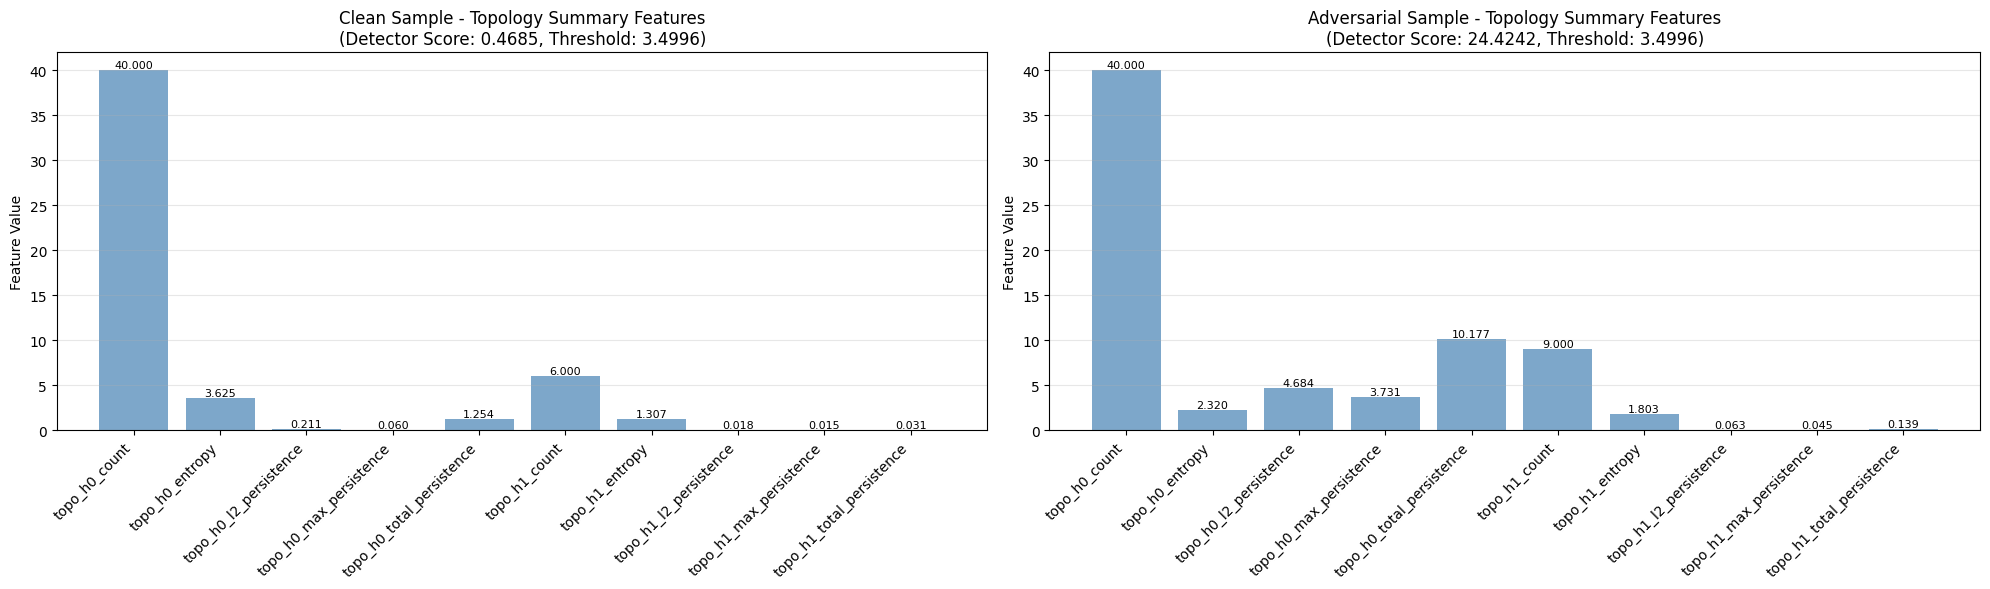


Topology Feature Comparison:
topo_h0_count                  Clean:  40.0000  Adversarial:  40.0000  Diff:   0.0000
topo_h0_entropy                Clean:   3.6249  Adversarial:   2.3197  Diff:  -1.3052
topo_h0_l2_persistence         Clean:   0.2113  Adversarial:   4.6836  Diff:   4.4723
topo_h0_max_persistence        Clean:   0.0603  Adversarial:   3.7310  Diff:   3.6708
topo_h0_total_persistence      Clean:   1.2544  Adversarial:  10.1769  Diff:   8.9225
topo_h1_count                  Clean:   6.0000  Adversarial:   9.0000  Diff:   3.0000
topo_h1_entropy                Clean:   1.3074  Adversarial:   1.8027  Diff:   0.4953
topo_h1_l2_persistence         Clean:   0.0178  Adversarial:   0.0628  Diff:   0.0450
topo_h1_max_persistence        Clean:   0.0148  Adversarial:   0.0446  Diff:   0.0297
topo_h1_total_persistence      Clean:   0.0314  Adversarial:   0.1394  Diff:   0.1080


In [26]:
# Visualize topology summary features
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Clean sample features
plot_topology_summary_features(
    clean_features,
    title=f"Clean Sample - Topology Summary Features\n(Detector Score: {clean_detector_score:.4f}, Threshold: {detector.threshold:.4f})",
    ax=axes[0]
)

# Adversarial sample features
plot_topology_summary_features(
    adv_features,
    title=f"Adversarial Sample - Topology Summary Features\n(Detector Score: {adv_detector_score:.4f}, Threshold: {detector.threshold:.4f})",
    ax=axes[1]
)

plt.tight_layout()
plt.show()

# Print feature comparison
print("\nTopology Feature Comparison:")
print("=" * 80)
for key in sorted(clean_features.keys()):
    clean_val = clean_features.get(key, 0.0)
    adv_val = adv_features.get(key, 0.0)
    diff = adv_val - clean_val
    print(f"{key:30s} Clean: {clean_val:8.4f}  Adversarial: {adv_val:8.4f}  Diff: {diff:8.4f}")
print("=" * 80)